<a href="https://colab.research.google.com/github/AnxietySquid/parkinsons_detection/blob/main/PRParkDesease_eremin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_path = '/content/drive/MyDrive/Colab Notebooks/TheFounder/PR/Parkinsons disease/Data/parkinsons.data'
df_desc_path = '/content/drive/MyDrive/Colab Notebooks/TheFounder/PR/Parkinsons disease/Data/parkinsons.names'
df = pd.read_csv(df_path)
with open(df_desc_path) as f:
  df_desc = f.read()

# Без сбалансированного датасета

## Data analysis and preparation

In [ ]:
print(df_desc)

Title: Parkinsons Disease Data Set

Abstract: Oxford Parkinson's Disease Detection Dataset

-----------------------------------------------------	

Data Set Characteristics: Multivariate
Number of Instances: 197
Area: Life
Attribute Characteristics: Real
Number of Attributes: 23
Date Donated: 2008-06-26
Associated Tasks: Classification
Missing Values? N/A

-----------------------------------------------------	

Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.

-----------------------------------------------------

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
rec

In [ ]:
display(df.head())

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
df.status.value_counts()

,count
status,
1,147
0,48


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

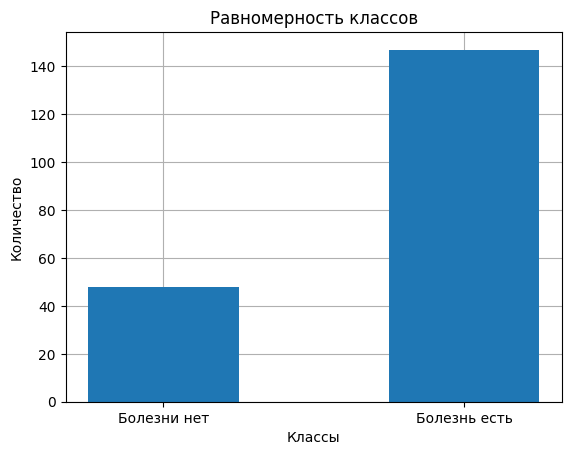

Количество здоровых: 48
Количество больных: 147


In [ ]:
# Убедимся, что данные распределены равномерно
plt.bar(df.status.value_counts().index, df.status.value_counts(), width=.5, zorder=2)
plt.title('Равномерность классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Болезни нет','Болезнь есть'])
plt.grid()
plt.show()

print(f'Количество здоровых: {df.status.value_counts()[0]}\nКоличество больных: {df.status.value_counts()[1]}')

In [ ]:
# Возьмём для тестовой выборки 10% от всех данных и сделать так, чтобы классов было поровну
df_test_positive = df.loc[df['status'] == 0, :].sample(n=15)
df_test_negative = df.loc[df['status'] == 1, :].sample(n=15)
df_test = pd.concat([df_test_positive, df_test_negative])

In [ ]:
# Уберём из датасета данные, которые взяли для тестовой выборки
df_train = df[~df.index.isin(df_test.index)]

In [ ]:
print(df_train.info())
print('-'*25)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              165 non-null    object 
 1   MDVP:Fo(Hz)       165 non-null    float64
 2   MDVP:Fhi(Hz)      165 non-null    float64
 3   MDVP:Flo(Hz)      165 non-null    float64
 4   MDVP:Jitter(%)    165 non-null    float64
 5   MDVP:Jitter(Abs)  165 non-null    float64
 6   MDVP:RAP          165 non-null    float64
 7   MDVP:PPQ          165 non-null    float64
 8   Jitter:DDP        165 non-null    float64
 9   MDVP:Shimmer      165 non-null    float64
 10  MDVP:Shimmer(dB)  165 non-null    float64
 11  Shimmer:APQ3      165 non-null    float64
 12  Shimmer:APQ5      165 non-null    float64
 13  MDVP:APQ          165 non-null    float64
 14  Shimmer:DDA       165 non-null    float64
 15  NHR               165 non-null    float64
 16  HNR               165 non-null    float64
 17  st

In [ ]:
# Лейблами тут будет столбце 'status', наш y_train
# За данные будут отвечать все остальные столбцы, кроме 'name', его просто уберём

x_train_prep = df_train.loc[:,df_train.columns!='status'].values[:, 1:]
x_test_prep = df_test.loc[:,df_test.columns!='status'].values[:, 1:]
y_train = df_train.loc[:, 'status'].values
y_test = df_test.loc[:, 'status'].values

# Также нужно нормализовать данные, чтобы модель не считала бОльшие значения более важными
# Можно даже не убирать
# от 0 до 1 по дефолту
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_prep)
x_test = scaler.fit_transform(x_test_prep)

In [ ]:
print(f'Первый элемент x_train: {x_train[0]}')
print('-'*25)
print(f'Весь y_train: {y_train}')
print('-'*25)
print('-'*25)
print(f'Форма x_train: {x_train.shape}')
print('-'*25)
print(f'Форма x_test: {x_test.shape}')
print('-'*25)
print(f'Форма y_train: {y_train.shape}')
print('-'*25)
print(f'Форма y_test: {y_test.shape}')

Первый элемент x_train: [0.18430827 0.11259173 0.05481479 0.1956798  0.24901186 0.14547206
 0.28749222 0.14528817 0.39919019 0.36206897 0.33889325 0.51343763
 0.27092181 0.33884892 0.0667028  0.5320796  0.37619513 0.96014836
 0.60038409 0.60788876 0.41505091 0.56771929]
-------------------------
Весь y_train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
-------------------------
-------------------------
Форма x_train: (165, 22)
-------------------------
Форма x_test: (30, 22)
-------------------------
Форма y_train: (165,)
-------------------------
Форма y_test: (30,)


## Fitting

In [ ]:
model_xgb = XGBClassifier()

In [ ]:
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model_xgb.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 80.0%


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

[[11  4]
 [ 2 13]]


Text(50.722222222222214, 0.5, 'Предсказанные значения')

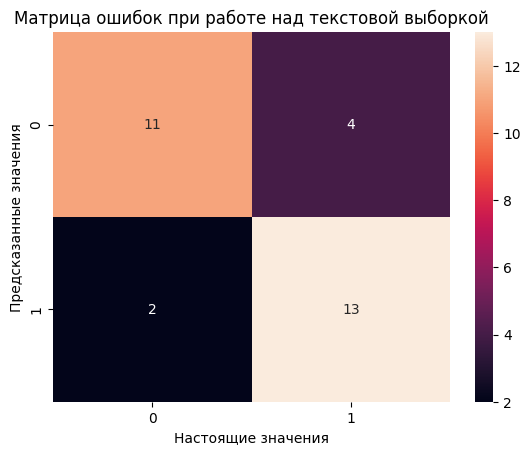

In [ ]:
sns.heatmap(cm, annot=True)
plt.title('Матрица ошибок при работе над текстовой выборкой')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказанные значения')

## Выводы

Датасет разбалансирован, что приводит к банальному угадыванию на данных, где пациент здоров при идеальной точности на больных пациентах  
Попробуем сбалансировать датасет и взять столько же больных, сколько и здоровых

# Со сбалансированным датасетом

## Data analysis and preparation

In [ ]:
n_to_drop = df.loc[df['status'] == 0, 'status'].shape[0]
df_ill_balanced = df.loc[df['status'] == 1, :].sample(n=n_to_drop)
df_healthy_balanced = df.loc[df['status'] == 0, :]
df_balanced = pd.concat([df_ill_balanced, df_healthy_balanced])
df_balanced.reset_index(drop=True, inplace=True)

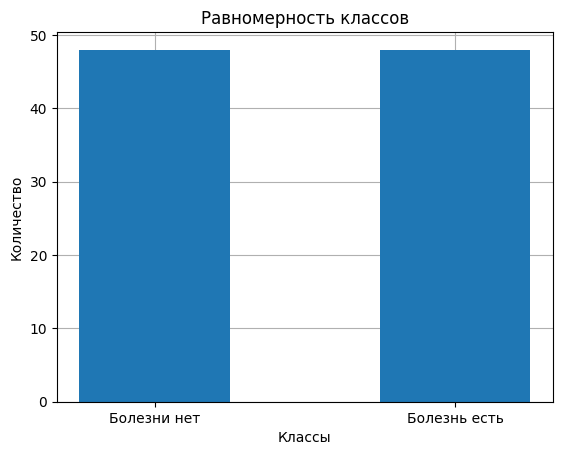

Количество здоровых: 48
Количество больных: 48


In [ ]:
# Убедимся, что данные распределены равномерно
plt.bar(df_balanced.status.value_counts().index, df_balanced.status.value_counts(), width=.5, zorder=2)
plt.title('Равномерность классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Болезни нет','Болезнь есть'])
plt.grid()
plt.show()

print(f'Количество здоровых: {df_balanced.status.value_counts()[0]}\nКоличество больных: {df_balanced.status.value_counts()[1]}')

In [ ]:
# Возьмём для тестовой выборки 10% от всех данных и сделать так, чтобы классов было поровну
df_test_positive = df_balanced.loc[df_balanced['status'] == 0, :].sample(n=15)
df_test_negative = df_balanced.loc[df_balanced['status'] == 1, :].sample(n=15)
df_test = pd.concat([df_test_positive, df_test_negative])

In [ ]:
# Уберём из датасета данные, которые взяли для тестовой выборки
df_train = df_balanced[~df_balanced.index.isin(df_test.index)]

In [ ]:
print(df_train.info())
print('-'*25)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 1 to 95
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              66 non-null     object 
 1   MDVP:Fo(Hz)       66 non-null     float64
 2   MDVP:Fhi(Hz)      66 non-null     float64
 3   MDVP:Flo(Hz)      66 non-null     float64
 4   MDVP:Jitter(%)    66 non-null     float64
 5   MDVP:Jitter(Abs)  66 non-null     float64
 6   MDVP:RAP          66 non-null     float64
 7   MDVP:PPQ          66 non-null     float64
 8   Jitter:DDP        66 non-null     float64
 9   MDVP:Shimmer      66 non-null     float64
 10  MDVP:Shimmer(dB)  66 non-null     float64
 11  Shimmer:APQ3      66 non-null     float64
 12  Shimmer:APQ5      66 non-null     float64
 13  MDVP:APQ          66 non-null     float64
 14  Shimmer:DDA       66 non-null     float64
 15  NHR               66 non-null     float64
 16  HNR               66 non-null     float64
 17  stat

In [ ]:
# Лейблами тут будет столбце 'status', наш y_train
# За данные будут отвечать все остальные столбцы, кроме 'name', его просто уберём

x_train_prep = df_train.loc[:,df_train.columns!='status'].values[:, 1:]
x_test_prep = df_test.loc[:,df_test.columns!='status'].values[:, 1:]
y_train = df_train.loc[:, 'status'].values
y_test = df_test.loc[:, 'status'].values

# Также нужно нормализовать данные, чтобы модель не считала бОльшие значения более важными
# Можно даже не убирать
# от 0 до 1 по дефолту
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_prep)
x_test = scaler.fit_transform(x_test_prep)

In [ ]:
print(f'Первый элемент x_train: {x_train[0]}')
print('-'*25)
print(f'Весь y_train: {y_train}')
print('-'*25)
print('-'*25)
print(f'Форма x_train: {x_train.shape}')
print('-'*25)
print(f'Форма x_test: {x_test.shape}')
print('-'*25)
print(f'Форма y_train: {y_train.shape}')
print('-'*25)
print(f'Форма y_test: {y_test.shape}')

Первый элемент x_train: [0.59064943 0.24937261 0.59482193 0.93360864 0.60474308 0.83429672
 1.         0.83432333 1.         1.         1.         1.
 1.         1.         0.6890537  0.         0.86167142 0.71736035
 1.         1.         0.94047616 1.        ]
-------------------------
Весь y_train: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-------------------------
-------------------------
Форма x_train: (66, 22)
-------------------------
Форма x_test: (30, 22)
-------------------------
Форма y_train: (66,)
-------------------------
Форма y_test: (30,)


## Fitting

In [ ]:
model_xgb = XGBClassifier()

In [ ]:
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model_xgb.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 90.0%


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

[[14  1]
 [ 2 13]]


Text(50.722222222222214, 0.5, 'Предсказанные значения')

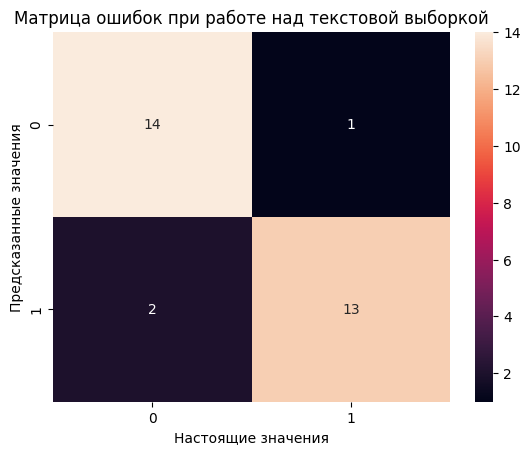

In [ ]:
sns.heatmap(cm, annot=True)
plt.title('Матрица ошибок при работе над текстовой выборкой')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказанные значения')

## Выводы ещё

Ну, теперь всё заработало как нужно, несмотря на сильное урезание базы
2 раза классификатор ошибся и принял здорового пациента за больного
Всего один раз классификатор принял больного за здорового